# Синусоида


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


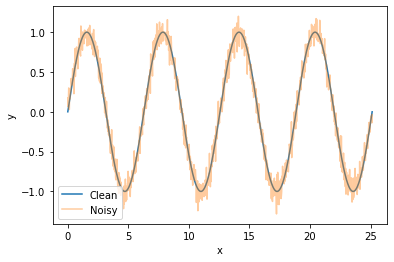

In [2]:
# Set random seed for reproducibility
np.random.seed(0)
torch.manual_seed(123)
# Define the range of x values
x = np.linspace(0, 8 * np.pi, 1000)

# Generate the clean sine wave
y_clean = np.sin(x)

# Generate white noise
noise = np.random.normal(0, 0.1, len(x))

# Add white noise to the clean sine wave
time_series = y_clean + noise

# Plot the clean and noisy sine wave
plt.plot(x, y_clean, label='Clean')
plt.plot(x, time_series, label='Noisy',alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Linear model with 3 lags 

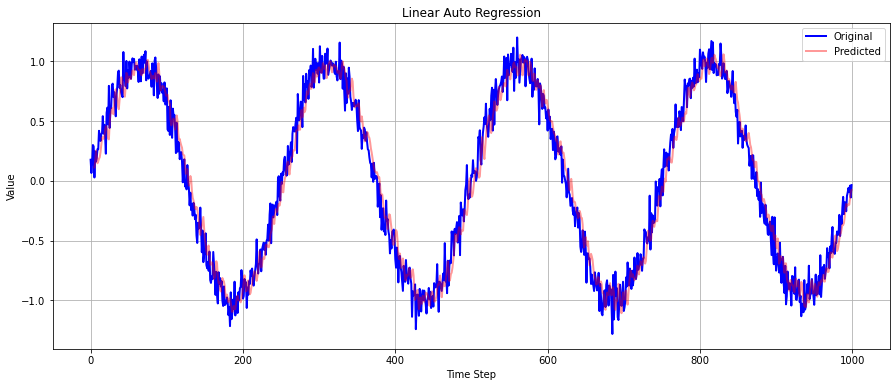

torch.Size([995, 3])
torch.Size([995, 1])


In [3]:
# Define the linear autoregression model
input_dim = 3  # Number of input values
output_dim = 1  # Number of output values
model = nn.Linear(input_dim, output_dim)

# Prepare the training data
x = torch.from_numpy(time_series[:-3]).float()
y = torch.from_numpy(time_series[5:]).float()

# Reshape the input data to have 3 values in each row
x = x.unfold(0, input_dim, 1).reshape(-1, input_dim)

# Reshape the target data to match the size of the predicted tensor
y = y[input_dim - 1:].unsqueeze(1)

# Pad the target tensor with zeros to match the input size
target_padding = torch.zeros((len(x) - len(y), 1))
y = torch.cat((y, target_padding))
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Train the model
num_epochs = 1000
losses = []

for epoch in range(num_epochs):
    outputs = model(x)
    loss = criterion(outputs, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# Generate predictions from the trained model
predicted = model(x).detach().numpy()

# Plot the original time series and predicted values
plt.figure(figsize=(15, 6))
plt.plot(time_series, color='blue', label='Original', linewidth=2)
plt.plot(range(5, len(time_series)), predicted[:, 0], color='red', label='Predicted', linewidth=2, alpha=0.4)
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Linear Auto Regression')
plt.legend()
plt.grid(True)
plt.show()
print(x.shape)
print(y.shape)

In [4]:
# Calculate MSE for each dimension
mse = torch.mean((torch.from_numpy(predicted) - y)**2, dim=0)

# Calculate MAE for each dimension
mae = torch.mean(torch.abs(torch.from_numpy(predicted) - y), dim=0)
print("MSE,MAE for original predict")
print(mse)
print(mae)

MSE,MAE for original predict
tensor([0.0236])
tensor([0.1252])


## FGSM Attack on the linear model 

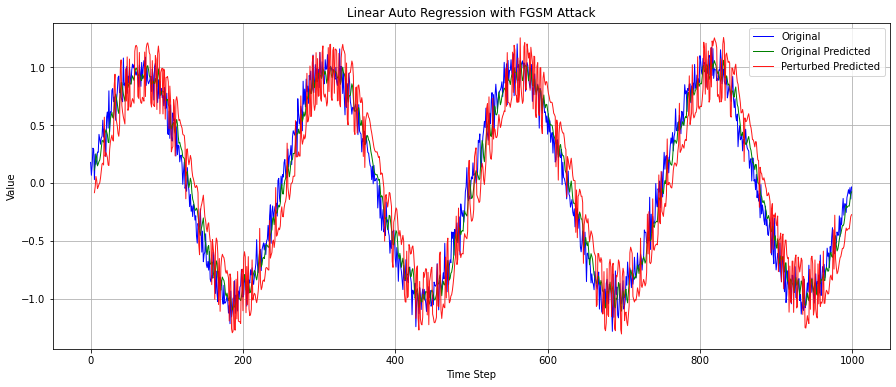

In [5]:

import torch.optim as optim
# Define the FGSM attack function
def fgsm_attack(data, epsilon, grad):
    sign_grad = grad.sign()
    perturbed_data = data + epsilon * sign_grad
    return perturbed_data


x.requires_grad = True
outputs = model(x)        
loss = criterion(outputs, y)
loss.backward(retain_graph=True)

# Perform FGSM attack
data_grad = x.grad.data
perturbed_data = fgsm_attack(x, 0.2, data_grad)
perturbed_outputs = model(perturbed_data)


# Generate predictions from the trained model with perturbed data
perturbed_predicted = model(perturbed_data).detach().numpy()

# Plot the original time series, original predictions, and perturbed predictions
plt.figure(figsize=(15,6))
plt.plot(time_series, color='blue', label='Original', linewidth=1)
#plt.plot(range(input_dim, len(time_series)), perturbed_data.detach().numpy()[:, 0], color='yellow', label='perturbed data', linewidth=1)
plt.plot(range(5, len(time_series)), predicted[:, 0], color='green', label='Original Predicted', linewidth=1)
plt.plot(range(5, len(time_series)), perturbed_predicted[:, 0], color='red', label='Perturbed Predicted', linewidth=1,alpha=0.9)
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Linear Auto Regression with FGSM Attack')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Calculate MSE for each dimension
mse = torch.mean((torch.from_numpy(perturbed_predicted) - y)**2, dim=0)

# Calculate MAE for each dimension
mae = torch.mean(torch.abs(torch.from_numpy(perturbed_predicted) - y), dim=0)
print("MSE,MAE for FGSM predict")
print(mse)
print(mae)


MSE,MAE for FGSM predict
tensor([0.1115])
tensor([0.3219])


## Bim Attack

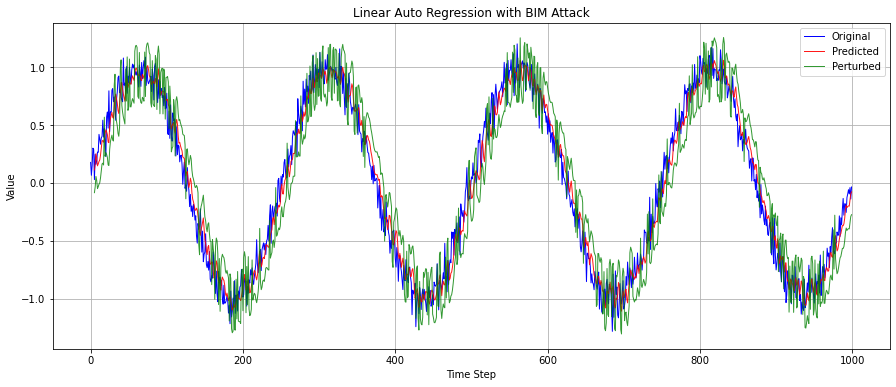

In [7]:

# BIM attack
def bim(X, Y, model, epsilon, alpha, I):
    perturbed_data = X.clone().detach().requires_grad_(True)
    for t in range(I):
        model.zero_grad()
        outputs = model(perturbed_data)
        loss = criterion(outputs, Y)
        loss.backward(retain_graph=True)
        sign_grad = perturbed_data.grad.data.sign()
        perturbed_data = perturbed_data + alpha * sign_grad
        perturbed_data = torch.clip(perturbed_data, X - epsilon, X + epsilon)
        perturbed_data = perturbed_data.detach().requires_grad_(True)
    return perturbed_data

# Perform BIM attack
perturbed_data = bim(x, y, model, epsilon=0.2, alpha=0.002, I=200)

# Generate predictions from the perturbed data
perturbed_x = perturbed_data.unsqueeze(1).float()
perturbed_predicted = model(perturbed_x).detach().numpy()

# Plot the original, predicted, and perturbed data
plt.figure(figsize=(15, 6))
plt.plot(time_series, color='blue', label='Original', linewidth=1)
plt.plot(range(5, len(time_series)), predicted[:, 0], color='red', label='Predicted', linewidth=1, alpha=0.9)
plt.plot(range(5, len(time_series)), perturbed_predicted[:, 0], color='green', label='Perturbed', linewidth=1, alpha=0.8)
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Linear Auto Regression with BIM Attack')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Calculate MSE for each dimension
mse = torch.mean((torch.from_numpy(perturbed_predicted).squeeze() - y.squeeze())**2, dim=0)

# Calculate MAE for each dimension
mae = torch.mean(torch.abs(torch.from_numpy(perturbed_predicted).squeeze() - y.squeeze()), dim=0)
print("MSE,MAE for BIM predict")
print(mse)
print(mae)

MSE,MAE for BIM predict
tensor(0.1115)
tensor(0.3219)
